In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib tk

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
## https://vishakh.me/posts/normalizing_flows/
## https://github.com/VincentStimper/normalizing-flows/blob/master/example/resflow.ipynb
## https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html
## https://deepgenerativemodels.github.io/notes/flow/

In [3]:
## 4, 4
def checkerboard(x, y):
    if x%2 < 1:
        if y%2 < 1:
            return True
        else:
            return False
    else:
        if y%2 < 1:
            return False
        else:
            return True

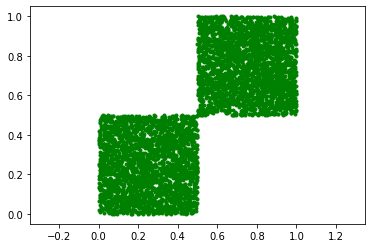

In [4]:
%matplotlib inline
xys = []
aa=2
for i in range(10000):
    xy = np.random.uniform(0, aa, size=2)
    if checkerboard(xy[0], xy[1]):
        xys.append(xy)
xys = np.array(xys)/aa
plt.axis('equal')
plt.scatter(xys[:,0], xys[:,1], marker='.', color='g')

In [5]:
xx = torch.Tensor(xys)
## we need network transforming x to z
x_ = torch.linspace(0,1, 50)
y_ = torch.linspace(0,1, 50)
x_, y_ = torch.meshgrid(x_, y_)
xy_ = torch.cat((x_.reshape(-1, 1), y_.reshape(-1,1)), dim=1)
xy_.shape

torch.Size([2500, 2])

In [6]:
class NFNet(nn.Module):
    
    def __init__(self, input_dim, num_layers, residual_dim=None, num_residual=1, activation=nn.LeakyReLU):
        super().__init__()
        self.input_dim = input_dim
        self.num_layers = num_layers
        self.residual_dim = residual_dim
        self.num_residual = num_residual
        if self.residual_dim is None:
            self.residual_dim = input_dim
        self.J = None
            
        ### build the network
        self.res_blocks = []
        for i in range(self.num_layers):
            res = []
            res.append(nn.utils.spectral_norm(
                nn.Linear(self.input_dim, self.residual_dim)))
            res.append(activation())
            for j in range(self.num_residual-1):
                res.append(nn.utils.spectral_norm(
                    nn.Linear(self.residual_dim, self.residual_dim)))
                res.append(activation())
            res.append(nn.utils.spectral_norm(
                nn.Linear(self.residual_dim, self.input_dim)))
            self.res_blocks.append(nn.Sequential(*res))
        self.res_blocks = nn.ModuleList(self.res_blocks)
        
    def forward(self, x):
        self.J = None
        for res in self.res_blocks:
            x = x + res(x)
        return x
    
    def _gaussian(self, z):
        b, io = z.shape
        return torch.exp(
                    -0.5*torch.matmul(z.reshape(b, 1, io), z.reshape(b, io, 1)).reshape(b,1)
                        )/np.sqrt((2*np.pi)**io)
    
    def gaussian(self, z, J):
        return self._gaussian(z) #* torch.abs(torch.det(J).reshape(-1, 1))
    
    # https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/other-readings/chapter13.pdf
    def _NLL(self, z, exact_nll=False):
        b, io = z.shape
        if not exact_nll:
            return torch.matmul(z.reshape(b, 1, io), z.reshape(b, io, 1)).mean()
        else:
            return 0.5*(\
                        torch.matmul(z.reshape(b, 1, io), z.reshape(b, io, 1)).mean() +\
                        io*np.log(2*np.pi) \
                        )
    def NLL(self, z, J, exact_nll=False):
        return self._NLL(z, exact_nll) + torch.abs(torch.det(J)).log().mean()
        

In [7]:
nfnet = NFNet(2, 10, residual_dim=15)
for i in range(20):
    zz = nfnet(xx)
    
optimizer = torch.optim.Adam(nfnet.parameters(), lr=0.001)

In [8]:
def get_jacobian(X, Z, requires_grad=True):
    b, i, o = X.shape[0], X.shape[1], Z.shape[1]
    J = torch.zeros (b, i, o)   # loop will fill in Jacobian
#     X.grad = None
    for j in range(o):
        grd = torch.zeros((b, o))   # same shape as zz
        grd[:, j] = 1    # column of Jacobian to compute
        Z.backward(gradient=grd, retain_graph=True, create_graph=requires_grad)
        J[:,:,j] = X.grad   # fill in one column of Jacobian
        X.grad.zero_()   # .backward() accumulates gradients, so reset to zero
    return J

In [9]:
%matplotlib tk
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

for epoch in range(10000):
    XX = xx.detach().requires_grad_()
    zz = nfnet(XX)
    J = get_jacobian(XX, zz)
#     break

    nll = nfnet.NLL(zz, J)

    optimizer.zero_grad()
    nll.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        
        XX = xy_.detach().requires_grad_()
        zz = nfnet(XX)
        J = get_jacobian(XX, zz)
        with torch.no_grad():
            px = nfnet.gaussian(zz, J)
            nll = nfnet.NLL(zz, J)

        print(f'Epoch: {epoch}  NLL: {nll}')
        ax.clear()
        ax.scatter(xy_[:,0], xy_[:,1], c=px[:,0], marker='.')
#         ax.legend()

        fig.canvas.draw()
        plt.pause(0.01)
        print("")

Epoch: 0  NLL: 25.19478988647461

Epoch: 100  NLL: -0.6627702713012695

Epoch: 200  NLL: -4.501155376434326

Epoch: 300  NLL: -14.66215991973877

Epoch: 400  NLL: -31.147836685180664

Epoch: 500  NLL: -27.820232391357422

Epoch: 600  NLL: -29.616130828857422

Epoch: 700  NLL: -29.738372802734375

Epoch: 800  NLL: -31.60299301147461



KeyboardInterrupt: 

In [ ]:
J

In [ ]:
# zz = nfnet(xx)
# J = torch.autograd.functional.jacobian(lambda x:nfnet(x), xx[0])
# J.shape
# # XX = xx*1.0
# # XX.requires_grad=True
# # torch.autograd.backward(zz, XX)